In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip uninstall scipy

!pip install scipy==1.1.0

In [ ]:
from tensorflow.python.keras.layers.core import Layer
import tensorflow as tf
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D,MaxPool2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from tensorflow.keras.optimizers import Adam, SGD

import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from numpy import asarray
from numpy import unique
from numpy import argmax
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import matplotlib.pyplot as plt
# import numpy as np
import os
from PIL import Image
# import tensorflow as tf
import imageio
# from scipy.misc import imresize

In [ ]:
class SpatialTransformer(Layer):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Borrowed from [2]_:
    downsample_fator : float
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
    """

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable = self.locnet.trainable_weights
        # self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*width_float
        y = .5*(y + 1.0)*height_float

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
        y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        # num_channels = tf.shape(input_shape)[3]
        num_channels = 1

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?
        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

        # transformed_grid = tf.batch_matmul(affine_transformation, indices_grid)
        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                              x_s_flatten,
                                              y_s_flatten,
                                              output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                 output_height,
                                                                 output_width,
                                                                 num_channels))
        return transformed_image

In [ ]:
batch_size = 128
nb_classes = 2
nb_epoch = 12


In [ ]:
IMG_WIDTH=440
IMG_HEIGHT=440

img_folder=r'/content/drive/MyDrive/pocus-dataset'

def create_dataset_PIL(img_folder):
    
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            #print(file)
            image_path= os.path.join(img_folder, dir1,  file)
            
            img_read=Image.open(image_path)
            # print(img_read.mode)
           
            img_read = img_read.convert('RGB')
            image= np.array(img_read)
            image= np.resize(image,(IMG_HEIGHT,IMG_WIDTH,1))
           
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array , class_name

PIL_img_data, class_name=create_dataset_PIL(img_folder)

target_dict={k: v for v, k in enumerate(np.unique(class_name))}
#target_dict
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]
n_classes=len(target_dict)

data=np.array(PIL_img_data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(target_val), test_size=0.30)

img_folder=r'/content/drive/MyDrive/test-pocus-dataset'

PIL_img_data, class_name=create_dataset_PIL(img_folder)

target_dict={k: v for v, k in enumerate(np.unique(class_name))}
#target_dict
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]
n_classes=len(target_dict)

X_test=np.array(PIL_img_data)
y_test=np.array(target_val)
print(y_test)

[0 0 0 0 0 0 0 0 1 1 1]


In [ ]:
DIM = 440

# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))


input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (440,440,1)
print("Input shape:",input_shape)
print(y_train)

Train samples: (1903, 440, 440, 1)
Validation samples: (816, 440, 440, 1)
Test samples: (11, 440, 440, 1)
Input shape: (440, 440, 1)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


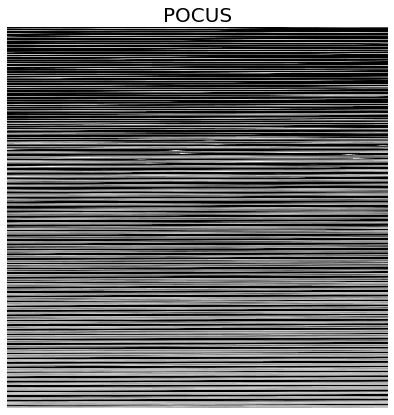

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('POCUS', fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((96800, 6), dtype='float32')
weights = [W, b.flatten()]

In [ ]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam, SGD
locnet = Sequential()
locnet.add(Convolution2D(16, (3, 3), input_shape = input_shape, padding='same'))
locnet.add(Activation('relu'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(8, (3, 3), padding='same' ))
locnet.add(Activation('relu'))
locnet.add(MaxPooling2D(pool_size=(2,2)))

locnet.add(Flatten())
#locnet.add(Dense(100))
locnet.add(Activation('sigmoid'))
locnet.add(Dense(6, weights=weights))
locnet.add(Activation('sigmoid'))



In [ ]:
##Alternative Layer for STN
#locnet = Sequential()
# locnet.add(MaxPool2D(pool_size=(2,2), input_shape=input_shape))
# locnet.add(Conv2D(32, (5, 5)))
# locnet.add(MaxPool2D(pool_size=(2,2)))
# locnet.add(Conv2D(32, (5, 5)))

# locnet.add(Flatten())
# locnet.add(Dense(50))
# locnet.add(Activation('relu'))
# locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))
# locnet.add(Conv2D(1, 8, kernel_size=7),MaxPool2D(2, stride=2),ReLU(True),Conv2D(8, 10, kernel_size=5),MaxPool2D(2, stride=2),ReLU(True))

In [ ]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,output_size=(30,30), input_shape=input_shape))

model.add(Conv2D(32, kernel_size=(3, 3),input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (2, 2)))
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(1, 1)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

In [ ]:
print(X_train.shape[0]/batch_size)

14.8671875


In [ ]:
model.fit(X_train, y_train,steps_per_epoch=8, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
8/8 [==============================] - 106s 13s/step - loss: 0.6745 - accuracy: 0.6008
Epoch 2/100
8/8 [==============================] - 101s 13s/step - loss: 0.6242 - accuracy: 0.5555
Epoch 3/100
8/8 [==============================] - 102s 13s/step - loss: 0.5955 - accuracy: 0.6170
Epoch 4/100
8/8 [==============================] - 103s 13s/step - loss: 0.5594 - accuracy: 0.6698
Epoch 5/100
8/8 [==============================] - 108s 13s/step - loss: 0.5268 - accuracy: 0.7225
Epoch 6/100
8/8 [==============================] - 99s 12s/step - loss: 0.5043 - accuracy: 0.7401
Epoch 7/100
8/8 [==============================] - 106s 13s/step - loss: 0.4733 - accuracy: 0.7663
Epoch 8/100
8/8 [==============================] - 107s 13s/step - loss: 0.4950 - accuracy: 0.7474
Epoch 9/100
8/8 [==============================] - 108s 13s/step - loss: 0.4187 - accuracy: 0.7678
Epoch 10/100
8/8 [==============================] - 100s 13s/step - loss: 0.3989 - accuracy: 0.7867
Epoch 11/1

In [ ]:
scorev = model.evaluate(X_valid, y_valid, verbose=1)
scoret = model.evaluate(X_test, y_test, verbose=1)
# print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))

1/1 [==============================] - 0s 494ms/step - loss: 0.0638 - accuracy: 1.0000


In [ ]:
# fig = plt.figure()
# try:
#     for e in range(nb_epoch):
#         print('-'*40)
#         #progbar = generic_utils.Progbar(X_train.shape[0])
#         for b in range(10):
#             #print(b)
#             f = b * batch_size
#             l = (b+1) * batch_size
#             X_batch = X_train[f:l].astype('float32')
#             y_batch = y_train[f:l].astype('float32')
#             loss = model.train_on_batch(X_batch, y_batch)
#             #print(loss)
#             #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
#         scorev = model.evaluate(X_valid, y_valid, verbose=1)
#         scoret = model.evaluate(X_test, y_test, verbose=1)
#         print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
#         if e % 1 == 0:
#             Xresult = F([X_batch[:9]])
#             plt.clf()
#             for i in range(9):
#                 plt.subplot(3, 3, i+1)
#                 image = np.squeeze(Xresult[0][i])
#                 plt.imshow(image, cmap='gray')
#                 plt.axis('off')
#             fig.canvas.draw()
#             plt.show()
        
# except KeyboardInterrupt:
#     pass

In [ ]:
pred=model.predict(X_test[:4],verbose=1)

1/1 [==============================] - 0s 202ms/step


In [ ]:
for i in X_test:
  image = i
  yhat = model.predict(asarray([image]))
  print('Predicted: class=%d' % argmax(yhat))

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
